## The SIR-model applied to the Corona-pandemic

In epidemiology, the SIR-model is a simple compartmental model that can be applied to an outbreak like the Corona-pandemic.

This model distinguishes Susceptible, Infected, and Recovered (or Removed) fractions of the population. Susceptible people can get infected, and infected persons eventually recover (or die), but do not become infected again.

<img src="https://dl.acm.org/cms/attachment/beab90df-5276-4223-9e65-682ac8013686/image1.png" width="50%" height="50%">

The fraction that newly catches the disease is proportional to both the available susceptible fraction that can acquire the disease (S) and the infected fraction that can transfer the disease (I): [S→I]=α⋅S⋅I, where α is the infection rate. <br>
<br>
The population fraction that recovers (or dies) is proportional to only the fraction of infected people itself (I): [I→R]=β⋅I, where β is the recovery rate.<br>
<br>

Thus, we obtain a set of differential equations:
  


<li> d/dt S = − α⋅S⋅I  </li>
<li> d/dt I=+α⋅S⋅I−β⋅I  </li>
<li> d/dt R=+β⋅I  </li>
   
For Covid-19, estimated infection and recovery rates are not well known, but during the initial phases of the pandemic these amounted to approximately α=0.25 day-1 and β=0.10 day<sup>-1</sup>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def SIR_Model(t, y):
    return np.array([
        -(0.25) * y[0] * y[1],               # Suseptible
         (0.25) * y[0] * y[1] - 0.10 * y[1], # Infected
         (0.10) * y[1]                       # Recovered
    ])


In [3]:
def Kutta(f, y0, t, h):
    
    steps = int(t / h) + 1
    h = t / steps

    xs = np.linspace(0, t, steps + 1)
    y = y0
    for x in xs[:-1]:
        k0 = f(x, y)
        k1 = f(x + (h/2) , y + (h/2)*k0)
        k2 = f(x + (h/2) , y + (-h)*k0 + 2*h*k1 )
        y = y + (h*(k0 + 4*k1 + k2))/ 6
    return  y

In [4]:
def model(t):
    return Kutta(SIR_Model, np.array([0.99, 0.01, 0.0]), t, h = 0.25)

In [5]:
ts = np.linspace(0,150,1000)
ys = [model(t) for t in ts]

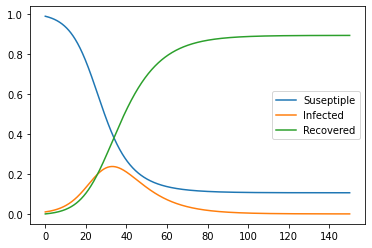

In [6]:
plt.plot(ts, ys)
plt.legend(['Suseptiple', 'Infected', 'Recovered'])
plt.show()

In [7]:
def Suseptible(t):
    return model(t)[0]
def Infected(t):
    return model(t)[1]
def Recovered(t):
    return model(t)[2]
def equal(t):
    return model(t)[0] - model(t)[2]
    

In [8]:
ys = [Infected(t) for t in ts]

In [9]:
def maximumsearch(f, a, b, steps):
    """lo, hi = minimumsearch(f, a, b, steps).
    Searches the interval (a,b) in a number of steps for
    the bounds (lo,hi) of the minima of f(x).
    """
    if steps < 2:
        steps = 2
    h = (b- a) / steps
    lo = a
    md = a + h 
    f_lo = f(lo)
    f_md = f(md)
    for i in range(2, steps +1):
        hi = a + h * i
        f_hi = f(hi)
        
        if f_md > f_lo and f_md >= f_hi:  # if operant '>' algo finds maxima else finds minimum
            yield lo, hi
            
        lo, f_lo = md, f_md    
        md, f_md= hi, f_hi

In [10]:
from math import sqrt
# Slower than bisection
def golden_search(f, a, b, tol=1e-8):
    """minimum = golden_search(f, a, b, tol=...).
    Finds a minimum of the function f using golden
    section search, starting from bracketing values
    a and b and ending when |b-a| < tol.
    """
    factor = (3.0 - sqrt(5.0)) / 2.0

    x1 = a + factor * (b - a)
    x2 = b - factor * (b - a)
    f1 = f(x1)
    f2 = f(x2)
    while abs(b-a) > tol:
        if f1 < f2: # if operant '>' algo finds maxima else finds minimum
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + factor * (b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 =  b - factor * (b - a)
            f2 = f(x2)
            
            
    return (a + b) / 2.0

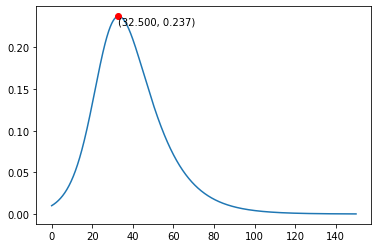

Covid Infections peaked at day: 32.500


In [11]:
plt.plot(ts, ys)

# plt.axis([-6, 6, -6, 1])
for (lo, hi) in list(maximumsearch(Infected, 10, 60, 100)):
    xmin = golden_search(Infected,lo, hi, 1e-6)
    ymin = Infected(xmin)
    plt.plot(xmin, ymin, 'or')
    plt.text(xmin, ymin, f'({xmin:.3f}, {ymin:.3f})', verticalalignment='top')
plt.show()
print(f'Covid Infections peaked at day: {xmin :.3f}')

In [12]:
ys = [equal(t) for t in ts]

In [14]:
def rootsearch(f, a, b, steps):
    """lo, hi = rootsearch(f, a, b, steps).
    Searches the interval (a,b) in a number of steps for
    the bounds (lo,hi) of the roots of f(x).
    """
    h = (b - a) / steps
    f_lo = f(a)
    for step in range(steps):
        lo = a + step * h
        hi = lo + h
        f_hi = f(hi)
        if f_lo * f_hi <= 0.0:
            yield lo, hi
        f_lo = f_hi

In [15]:

def ridder(f,a,b,tol=1.0e-9):
    
    lo, f_lo = a, f(a)
    if f_lo == 0.0:
        return lo
    hi, f_hi = b, f(b)
    if f_hi == 0.0:
        return hi
    if f_lo * f_hi > 0.0:
        raise ValueError('Root is not bracketed')
        
    while abs(hi - lo) > tol:
        mid = (hi + lo) / 2.0
        f_mid = f(mid)
        
        s= np.sqrt(f_mid**2 - f_lo*f_hi)
        if s == 0.0:
            return None
        dx = (mid - lo)*f_mid/s
        if (f_lo - f_hi) < 0.0:
            dx = -dx
        x = mid + dx
        fx = f(x)
        if (f_mid * fx > 0):
            if (f_lo * fx < 0):
                hi = x
                f_hi = f(hi)
            else:
                lo = x
                f_lo = f(lo)
        else:
            lo, hi, f_lo, f_hi = mid, x, f_mid, fx
    return x

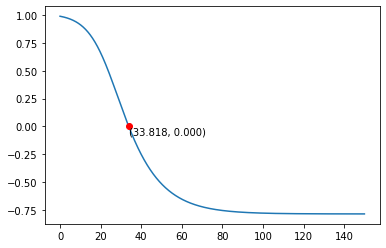

Suseptible and Recoveries where the same at day: 33.818


In [16]:
plt.plot(ts, ys)
for (lo, hi) in list(rootsearch(equal, 20, 60, 100)):
    xmin = ridder(equal,lo, hi, 1e-3)
    ymin = equal(xmin)
    plt.plot(xmin, ymin, 'or')
    plt.text(xmin, ymin, f'({xmin:.3f}, {ymin:.3f})', verticalalignment='top')
    

plt.show()
print(f'Suseptible and Recoveries where the same at day: {xmin :.3f}')

In [69]:
day = 33.818
day.hex()

'0x1.0e8b439581062p+5'

In [48]:
 (1 + 0/16**1 + 14/16**2+ 8/16**3 + \
      11/16**4 + 4/16**5 +          \
      3/16**6 + 9/16**7 + 5/16**8 + \
      8/16**9 + 1/16**10+ 0/16**11 +\
      6/16**12 + 2/16**13 ) * 2.0**5

33.818

or

In [68]:
print(float.fromhex('0x1.0e8b439581062p+5'))

33.818


In [65]:
print(33//2, 33%2)
print(16//2, 16%2)
print(8//2 , 8%2)
print(4//2 , 4%2)
print(2//2 , 2%2)
print(1//2 , 1%2)
print('33 to binary: 100001')
print(bin(33))

16 1
8 0
4 0
2 0
1 0
0 1
33 to binary: 100001
0b100001


33.818

In [44]:
print(0.818*2, 0.636, 1)
print(0.636*2, 0.272, 1)
print(0.272*2, 0.544, 0)
print(0.544*2, 0.088, 1)
print(0.088*2, 0.176, 0)
print(0.176*2, 0.352, 0)
print()
print('0.818 is almost: 110100')

1.636 0.636 1
1.272 0.272 1
0.544 0.544 0
1.088 0.088 1
0.176 0.176 0
0.352 0.352 0

0.818 is almost: 110100


In [45]:
print('33.818 is almost 100001.110100')

33.818 is almost 100001.110100


scientific notation 1.00001110100 x2^5

In [19]:
def simpson(f, a, b, n=100):
    """df = simpson(f, a, b, n=...).
    Calculates the definite integral of the function f(x)
    from a to b using the composite Simpson's
    rule with n subdivisions (with default n=...).
    """
    
    n += n % 2 # force to be even
    
    h = (b -a) / n 
    
    I = f(a) + f(b)
    
    for i in range(1, n, 2):
        xi = a + i*h
        I += 4*f(xi)
        
    for i in range(2, n, 2):
        xi = a + i*h
        I += 2*f(xi)
    I *= h/3
    
    return I

In [22]:
auc = simpson(Infected, 5, 60)
print(f'The auc for infections from day 5 to day 60 is : {auc :.3f}')

The auc for infections from day 5 to day 60 is : 7.847


In [54]:
simpson(Infected, 0, 150) + simpson(Recovered, 0, 150) + simpson(Suseptible, 0, 150)

150.0

In [50]:
simpson(Recovered, 0, 150)

99.27146430487679

In [51]:
simpson(Suseptible, 0, 150)

41.78891068602636